<a href="https://colab.research.google.com/github/nader-hachana/Time_Series_Forecasting/blob/main/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import os

In [27]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory


In [28]:
import pandas as pd
from matplotlib import pyplot
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statistics



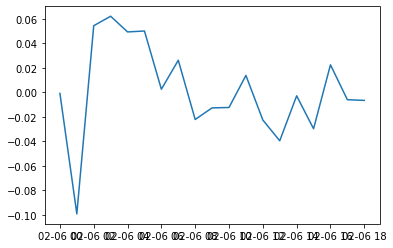

In [29]:
hourly_sentiment_series = pd.read_csv('./hourly_users_sentiment_subset.csv',
                                      index_col = 0,
                                      parse_dates = True,
                                      squeeze = True # If the parsed data only contains one column then return a Series
                                      )
#print(hourly_sentiment_series)
#print(hourly_sentiment_series.index)

#print(hourly_sentiment_series.head())
#print(hourly_sentiment_series.tail())
#print(hourly_sentiment_series.shape)

pyplot.plot(hourly_sentiment_series)
pyplot.show()

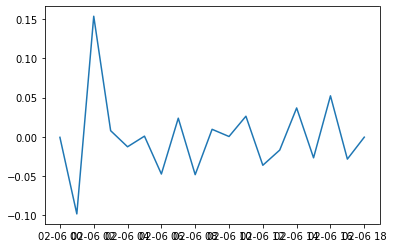

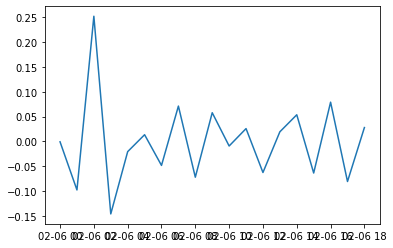

In [30]:
# Make data looks more stationary
# we need to difference the data and make sure not to over difference it so we can get accurate estimates

hourly_sentiment_series_diff1 = hourly_sentiment_series.diff().fillna(hourly_sentiment_series)
pyplot.plot(hourly_sentiment_series_diff1)
pyplot.show()

hourly_sentiment_series_diff2 = hourly_sentiment_series_diff1.diff().fillna(hourly_sentiment_series_diff1)
pyplot.plot(hourly_sentiment_series_diff2)
pyplot.show()



/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


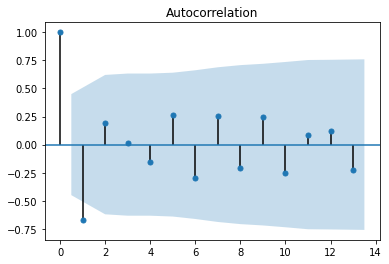

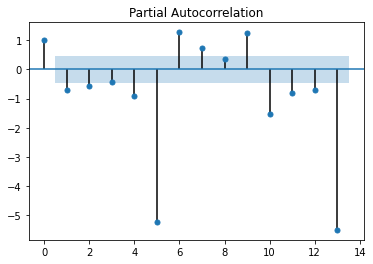

In [44]:
# modeling and forecasting

# ACF plot:
plot_acf(hourly_sentiment_series_diff2).show()

# PACF plot:
plot_pacf(hourly_sentiment_series_diff2).show()

# ACF and PACF plot includes a 95% confidence interval band.
# If we see a significant spike at tag X in the ACF, that helps us determine the number of moving average terms.
# If we see a significant spike at tag X in the PACF, that helps us determine the number of autoregressive term.


In [32]:
ARIMA1model_hourly_sentiment = ARIMA(hourly_sentiment_series, order =(5, 2, 1)).fit(transparams=False) #order of the model for the autoregressive, differences, and moving average components
print(ARIMA1model_hourly_sentiment.summary())

# It's not significant enough of a term to keep in the model cause (P > |z|, z = 0.05), we are going to remodel only on "ma" (P = 0.001)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                                ARIMA Model Results                                 
Dep. Variable:     D2.users_sentiment_score   No. Observations:                   17
Model:                       ARIMA(5, 2, 1)   Log Likelihood                  27.731
Method:                             css-mle   S.D. of innovations              0.041
Date:                      Thu, 07 Apr 2022   AIC                            -39.462
Time:                              12:47:11   BIC                            -32.796
Sample:                          02-06-2019   HQIC                           -38.799
                               - 02-06-2019                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.0007      0.001     -0.505      0.624      -0.004       0.002
ar.L1.D2.users_sentimen

In [33]:
ARIMA1predict_5hourly_sentiment = ARIMA1model_hourly_sentiment.predict('2/6/2019 7:00:00 PM', '2/6/2019 11:00:00 PM', typ = 'levels')
# typ = 'levels' means that we are predicting on the original scale without the difference operation.
print('forecast/predictions\n', ARIMA1predict_5hourly_sentiment)


forecast/predictions
 2019-02-06 19:00:00   -0.008694
2019-02-06 20:00:00   -0.033364
2019-02-06 21:00:00   -0.014812
2019-02-06 22:00:00   -0.042334
2019-02-06 23:00:00   -0.038092
Freq: H, dtype: float64


In [39]:
# returning the second round of differences to the first round:
undiff1 = hourly_sentiment_series_diff2.cumsum().fillna(hourly_sentiment_series_diff2) #cumsum = cumulative sum
undiff2 = undiff1.cumsum().fillna(undiff1)

# compare it to the original values
print(all(round(hourly_sentiment_series, 6) == round(undiff2, 6)))
print('Original values', hourly_sentiment_series.head())
print('de-diffrenced values', undiff2.head())

True
Original values datetime
2019-02-06 00:00:00   -0.000745
2019-02-06 01:00:00   -0.099152
2019-02-06 02:00:00    0.054502
2019-02-06 03:00:00    0.062236
2019-02-06 04:00:00    0.049438
Name: users_sentiment_score, dtype: float64
de-diffrenced values datetime
2019-02-06 00:00:00   -0.000745
2019-02-06 01:00:00   -0.099152
2019-02-06 02:00:00    0.054502
2019-02-06 03:00:00    0.062236
2019-02-06 04:00:00    0.049438
Name: users_sentiment_score, dtype: float64


In [40]:
# Evaluating forecast/predictions:

hourly_sentiment_full_actual = pd.read_csv('./hourly_users_sentiment_sample.csv',
                                           index_col = 0,
                                           parse_dates = True,
                                           squeeze = True)
indx_row_values = hourly_sentiment_full_actual.index[19:24]
print(indx_row_values)

predicted_series_values = pd.Series(ARIMA1predict_5hourly_sentiment,
                                    #index =['2019-02-06 19:00:00', 
                                    #        '2019-02-06 20:00:00',
                                    #        '2019-02-06 21:00:00', 
                                    #        '2019-02-06 22:00:00',
                                    #        '2019-02-06 23:00:00']
                                    )
print(predicted_series_values)

DatetimeIndex(['2019-02-06 19:00:00', '2019-02-06 20:00:00',
               '2019-02-06 21:00:00', '2019-02-06 22:00:00',
               '2019-02-06 23:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)
2019-02-06 19:00:00   -0.008694
2019-02-06 20:00:00   -0.033364
2019-02-06 21:00:00   -0.014812
2019-02-06 22:00:00   -0.042334
2019-02-06 23:00:00   -0.038092
Freq: H, dtype: float64


In [41]:
hourly_sentiment_full_predicted = hourly_sentiment_series.append(predicted_series_values)
print(hourly_sentiment_full_predicted.tail())

2019-02-06 19:00:00   -0.008694
2019-02-06 20:00:00   -0.033364
2019-02-06 21:00:00   -0.014812
2019-02-06 22:00:00   -0.042334
2019-02-06 23:00:00   -0.038092
dtype: float64


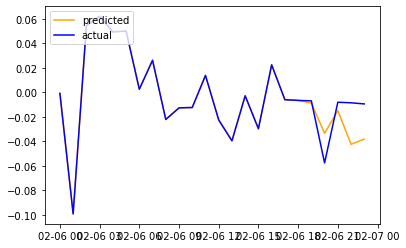

In [42]:
pyplot.plot(hourly_sentiment_full_predicted, c='orange', label ='predicted')
pyplot.plot(hourly_sentiment_full_actual, c='blue', label ='actual')
pyplot.legend(loc='upper left')
pyplot.show()

In [43]:
# Calculating prediction errors:

actual_values_holdout = hourly_sentiment_full_actual.iloc[19:24]
predicted_values_holdout = hourly_sentiment_full_predicted.iloc[19:24]

prediction_errors =[]
for i in range(len(actual_values_holdout)):
    err = actual_values_holdout[i]-predicted_values_holdout[i]
    prediction_errors.append(err)
print('Prediction errors ', prediction_errors)

mean_absolute_error = statistics.mean(map(abs, prediction_errors))
print('Mean absolute error ', mean_absolute_error)

test_results = adfuller(hourly_sentiment_series_diff2)
print(test_results)
print('p-value ', test_results[1])
# if the p-value is greater than 0.05, which is our significance level,
# we'll accept the null hypothesis as the data is non-stationary.
# And if it's less than or equal to 0.05 we're going to reject that null hypothesis
# and say that the data is stationary.

Prediction errors  [0.0018542084232047755, -0.024176480638740595, 0.006822361022179518, 0.033904219397906964, 0.028751991564993]
Mean absolute error  0.01910185220940497
(-6.187133201635743, 6.249784793631464e-08, 1, 17, {'1%': -3.889265672705068, '5%': -3.0543579727254224, '10%': -2.66698384083045}, -39.94819525889858)
p-value  6.249784793631464e-08
